Program: 08_kmeans_test.R  
Date: September, 2019  
Programmer: Hillary Mulder  
Purpose: Show K means doesnt work well with harmonized trials data

In [2]:
library(cluster)
library(caret)
library(purrr)
library(dplyr)
library(boot)
#library(table1)
library(Hmisc)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘purrr’

The following object is masked from ‘package:caret’:

    lift


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘boot’

The following object is masked from ‘package:lattice’:

    melanoma

Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:boot’:

    aml

The following object is masked from ‘package:caret’:

    cluster

Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units



In [1]:
data=read.csv("/mnt/workspace/DCRI/Data/analysis_ds.csv")

data$allhat=ifelse(data$study.1=='ALLHAT', 1, 0)
data$aimhigh=ifelse(data$study.1=='AIMHIGH', 1, 0)
data$accord=ifelse(data$study.1=='ACCORD', 1, 0)

In [3]:
train=data[which(data$train==1),]
base_nmiss=train[complete.cases(train[, c(1:3, 5, 6, 9:19, 20:22, 50, 51, 56:58)]), c(1:3, 5, 6, 9:19, 20:22, 50, 51, 56:58)]
studyn=base_nmiss$study.1
enrolid=base_nmiss[,1]
base_nmiss=base_nmiss[, -c(1,20,21)]
#base_nmiss=base_nmiss[, -c(1,9,10,22,23)]
colnames(base_nmiss)
ppr=preProcess(base_nmiss, method=c('center','scale'))

#apply transformations
base_scale=predict(ppr, newdata=base_nmiss)

#base_scale=scale(base_nmiss)

[1] "age"     "Sex"     "Race2"   "BMI"     "Toba"    "Htn"     "HxDM"   
 [8] "HxMIStr" "revasc"  "BP.s"    "BP.d"    "LDL"     "HDL"     "TChol"  
[15] "Trig"    "HMG"     "asprin"  "antihyp" "allhat"  "aimhigh" "accord"

In [8]:
test=data[which(data$test==1),]
test_nmiss=test[complete.cases(test[, c(1:3, 5, 6, 9:19, 20:22, 50, 51, 56:58)]), c(1:3, 5, 6, 9:19, 20:22, 50, 51, 56:58)]
test_studyn=test_nmiss$study.1
test_enrolid=test_nmiss[,1]
test_nmiss=test_nmiss[, -c(1,20,21)]
#base_nmiss=base_nmiss[, -c(1,9,10,22,23)]
#test_scale=scale(_nmiss)
test_scale=predict(ppr, newdata=test_nmiss)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1233550)”

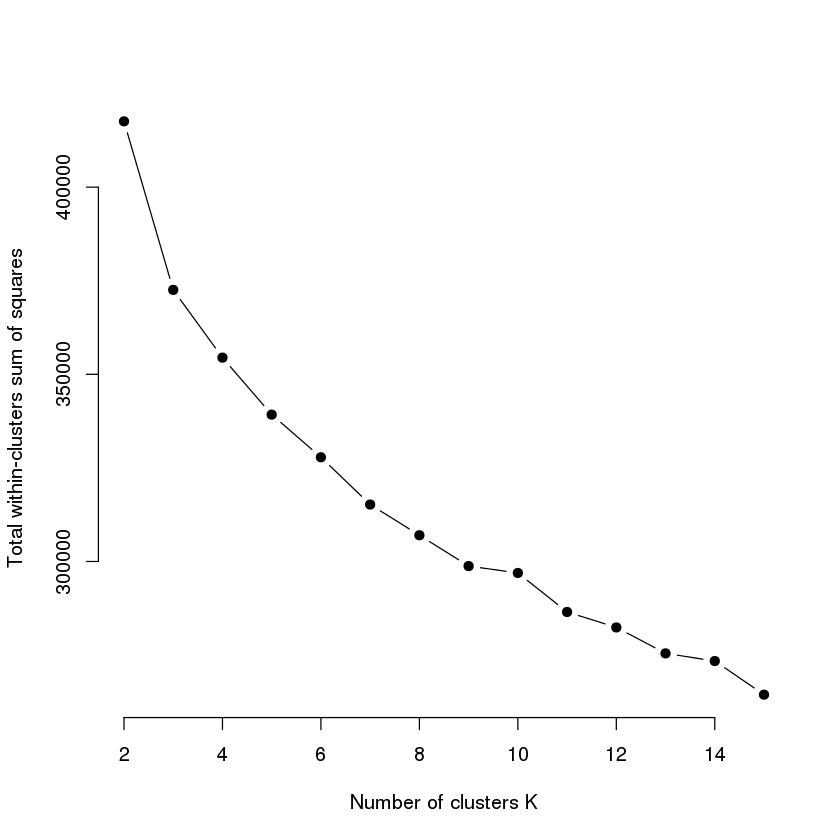

In [9]:
set.seed(123)

# function to compute total within-cluster sum of square 
wss <- function(k) {
  kmeans(base_scale, k, iter.max=20, nstart = 4)$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 2:15

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

plot(k.values, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters sum of squares")


In [10]:
#going to use 4 or 5 clusters

set.seed(123)
cluster1 <- kmeans(base_scale, 4, iter.max=15, nstart = 6)
cluster2 <- kmeans(base_scale, 5, iter.max=15, nstart = 6)

In [11]:
base_nmiss %>%
  mutate(Cluster = cluster1$cluster) %>%
  group_by(Cluster) %>%
  summarise_all("mean")

base_nmiss %>%
  mutate(Cluster = cluster2$cluster) %>%
  group_by(Cluster) %>%
  summarise_all("mean")

Cluster,age,Sex,Race2,BMI,Toba,Htn,HxDM,HxMIStr,revasc,⋯,LDL,HDL,TChol,Trig,HMG,asprin,antihyp,allhat,aimhigh,accord
1,66.20203,1.763118,1.546947,29.98012,0.7588217,0.9990795,0.3904572,0.1472844,0.0374348,⋯,149.14867,55.08592,231.7639,137.7203,0.07026695,0.2026695,0.8832464,0.9754525928,0.0001534213,0.0147284443
2,64.20194,1.157862,1.038762,31.18222,0.2119412,0.7352298,0.3732416,0.6130041,0.8415130,⋯,73.83182,34.70428,142.8387,182.2748,0.99968740,0.9130978,0.9753048,0.0000000000,0.9690528290,0.0000000000
3,67.35424,1.161920,1.145072,29.02157,0.8066199,0.9992545,0.3509766,0.3278664,0.2214105,⋯,125.15074,39.95915,197.6365,163.1928,0.05471895,0.5425675,0.9256001,0.9773371105,0.0001490980,0.0002981959
4,62.75689,1.376864,1.201528,32.32401,0.1894022,0.7888929,1.0000000,0.2209288,0.2017703,⋯,102.20359,41.25233,179.6225,187.5859,0.66581787,0.6004608,0.8914757,0.0007275373,0.0000000000,0.8696495695


Cluster,age,Sex,Race2,BMI,Toba,Htn,HxDM,HxMIStr,revasc,⋯,LDL,HDL,TChol,Trig,HMG,asprin,antihyp,allhat,aimhigh,accord
1,67.34462,1.160475,1.143931,28.99661,0.8041811,0.9990976,0.3478719,0.3263649,0.22168747,⋯,125.33373,39.93187,197.8290,163.4372,0.05143631,0.5424876,0.9246503,0.980899383,0.0001503986,0.0003007971
2,64.18786,1.162040,1.037121,31.17947,0.1939961,0.7340219,0.3531311,0.6039380,0.83699161,⋯,73.85152,34.78244,142.9135,182.5097,1.00000000,0.9112331,0.9754680,0.000000000,1.0000000000,0.0000000000
3,63.73523,1.256674,1.194661,31.90498,0.2535211,0.8120664,1.0000000,0.3262560,0.32730713,⋯,86.77402,39.62161,157.9287,160.2363,0.90372083,0.7675005,0.9743536,0.001261299,0.0000000000,0.7677107421
4,61.57733,1.531057,1.218607,32.78393,0.1320247,0.7647217,0.9997311,0.1064802,0.05888680,⋯,122.52541,43.65475,208.0024,220.7553,0.35681635,0.3904275,0.7843506,0.001344447,0.0005377790,0.9688088196
5,66.27866,1.761166,1.544820,29.97801,0.7678350,1.0000000,0.3812035,0.1477978,0.03753102,⋯,148.88431,54.92990,231.3173,137.5575,0.06947891,0.2016129,0.8863213,0.990384615,0.0001550868,0.0020161290


In [12]:
#table(base_nmiss$studyn, final$cluster)
check=data.frame(person_id=enrolid, study=studyn, cluster1=cluster1$cluster, cluster2=cluster2$cluster)
#head(check)
table(check$study, check$cluster1)
table(check$study, check$cluster2)

         
             1    2    3    4
  ACCORD    96    0    2 7172
  AIMHIGH    1 3100    1    0
  ALLHAT  6358    0 6555    6
  BARI2D    63   99  149 1069

         
             1    2    3    4    5
  ACCORD     2    0 3652 3603   13
  AIMHIGH    1 3098    0    2    1
  ALLHAT  6522    0    6    5 6386
  BARI2D   124    0 1099  109   48

In [13]:
#table(base_nmiss$studyn, final$cluster)
predict.kmeans <- function(object,
                           newdata,
                           method = c("centers", "classes")) {
  method <- match.arg(method)

  centers <- object$centers
  ss_by_center <- apply(centers, 1, function(x) {
    colSums((t(newdata) - x) ^ 2)
  })
  best_clusters <- apply(ss_by_center, 1, which.min)

  if (method == "centers") {
    centers[best_clusters, ]
  } else {
    best_clusters
  }
}

pred1=predict.kmeans(cluster1, newdata=test_scale, method="classes")
pred2=predict.kmeans(cluster2, newdata=test_scale, method="classes")
std=data.frame(person_id=test_enrolid, study=test_studyn, cluster1=pred1, cluster2=pred2)
#head(std)
table(std$study, std$cluster1)
table(std$study, std$cluster2)

         
             1    2    3    4
  ACCORD    25    0    0 2406
  AIMHIGH    0 1036    0    0
  ALLHAT  2050    0 2256    3
  BARI2D    25   37   46  351

         
             1    2    3    4    5
  ACCORD     0    0 1277 1151    3
  AIMHIGH    0 1036    0    0    0
  ALLHAT  2251    0    1    3 2054
  BARI2D    35    0  354   55   15

In [10]:
#train2=left_join(x=train, y=check, by='person_id')
#colnames(train)
#head(train)
#test2=left_join(x=test, y=std, by='person_id')

#all=rbind(train2, test2)
#head(all)
#write.csv(all, file='/mnt/workspace/DCRI/Data/analysis_ds_clusters.csv', quote = FALSE,  row.names = FALSE)

In [20]:
base_new=base_scale[,-(19:21)]
test_new=test_scale[,-c(19:21)]

set.seed(123)
cluster3 <- kmeans(base_new, 4, iter.max=15, nstart = 6)
cluster4 <- kmeans(base_new, 5, iter.max=15, nstart = 6)

#table(base_nmiss$studyn, final$cluster)
check=data.frame(person_id=enrolid, study=studyn, cluster3=cluster3$cluster, cluster4=cluster4$cluster)
#head(check)
table(check$study, check$cluster3)
table(check$study, check$cluster4)


pred3=predict.kmeans(cluster3, newdata=test_new, method="classes")
pred4=predict.kmeans(cluster4, newdata=test_new, method="classes")
std=data.frame(person_id=test_enrolid, study=test_studyn, cluster3=pred3, cluster4=pred4)
#head(std)
table(std$study, std$cluster3)
table(std$study, std$cluster4)

         
             1    2    3    4
  ACCORD   582 1385 4435  868
  AIMHIGH    9 2830  215   48
  ALLHAT  9949  524 1216 1230
  BARI2D   105  398  852   25

         
             1    2    3    4    5
  ACCORD  4018 1307  862  570  513
  AIMHIGH  241 2796   48    6   11
  ALLHAT   503  313 1230 3928 6945
  BARI2D   807  362   25  103   83

         
             1    2    3    4
  ACCORD   174  487 1486  284
  AIMHIGH    2  943   79   12
  ALLHAT  3274  186  410  439
  BARI2D    42  128  278   11

         
             1    2    3    4    5
  ACCORD  1354  468  282  151  176
  AIMHIGH   96  921   12    1    6
  ALLHAT   168  114  439 1312 2276
  BARI2D   261  117   11   40   30